In [94]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import tensorflow as tf
import time
from caps_net import CapsNet

In [95]:
PIXEL_DEPTH = 255.0
IMAGE_SIZE = 40;
CHANNELS = 1

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    if (img.shape[0] >= img.shape[1]):
        resizeto = (IMAGE_SIZE, int(round(IMAGE_SIZE * (float(img.shape[1]) / img.shape[0]))))
    else:
        resizeto = (int(round(IMAGE_SIZE * (float(img.shape[0])  / img.shape[1]))), IMAGE_SIZE)
    img = cv2.resize(img, (resizeto[1], resizeto[0]), interpolation=cv2.INTER_CUBIC)
#   img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.copyMakeBorder(img, 0, IMAGE_SIZE - img.shape[0], 0,
        IMAGE_SIZE - img.shape[1], cv2.BORDER_CONSTANT, 0)
    return img

def prep_images(images, normalize=True, pixel_depth=PIXEL_DEPTH):
    count = len(images)
    data = np.ndarray((count, IMAGE_SIZE, IMAGE_SIZE), dtype=np.float32)
#   for i in tqdm(range(count)):
    for i in range(count):
        image = read_image(images[i])
        image_data = np.array(image, dtype=np.float32)
        if normalize:
            image_data = image_data.astype(float) / pixel_depth
#             image_data[:,:,1] = image_data[:,:,1].astype(float) / pixel_depth
#             image_data[:,:,2] = image_data[:,:,2].astype(float) / pixel_depth
        data[i] = image_data
    return data

def randomize_data(data):
    data = np.array(data)
    permutation = np.random.permutation(data.shape[0])
    shuffled_data = data[permutation]
    return shuffled_data

def next_batch(x, y, batch_index, batch_size):
    start = batch_index*batch_size
    end = batch_index*batch_size+batch_size
    x_batch = x[start:end]
    if y is not None:
        y_batch = y[start:end]
        return x_batch, y_batch
    else:
        return x_batch
    
def fetch_batch(size, x, y):
    idx = np.arange(0 , len(x))
    np.random.shuffle(idx)
    idx = idx[:size]
    data_shuffle = [x[i] for i in idx]
    labels_shuffle = [y[i] for i in idx]
    return np.asarray(data_shuffle), np.asarray(labels_shuffle)
    
def create_val_set(data, labels, valid_size):
    data_size = data.shape[0]
    all_indices = np.array((range(data_size)))
    val_indices = np.random.choice(range(data_size), valid_size, replace=False)
    train_indices = np.delete(all_indices, val_indices)
    data_train = np.delete(data, val_indices, axis=0)
    label_train = np.delete(labels, val_indices, axis=0)
    data_val = np.delete(data, train_indices, axis=0)
    label_val = np.delete(labels, train_indices, axis=0)
    return data_train, label_train, data_val, label_val

In [96]:
TRAIN_DIR = './data/train/'
TEST_DIR = './data/test1/'

valid_size = 50

train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]
train_images = randomize_data(train_images)

train_dataset, train_labels,\
valid_dataset, valid_labels = create_val_set(train_images, train_images, valid_size)

print('Train dataset shape: {}'.format(train_dataset.shape))
print('Train labels shape: {}'.format(train_labels.shape))
print('Validation dataset shape: {}'.format(valid_dataset.shape))
print('Validation labels shape: {}'.format(valid_labels.shape))

Train dataset shape: (24950,)
Train labels shape: (24950,)
Validation dataset shape: (50,)
Validation labels shape: (50,)


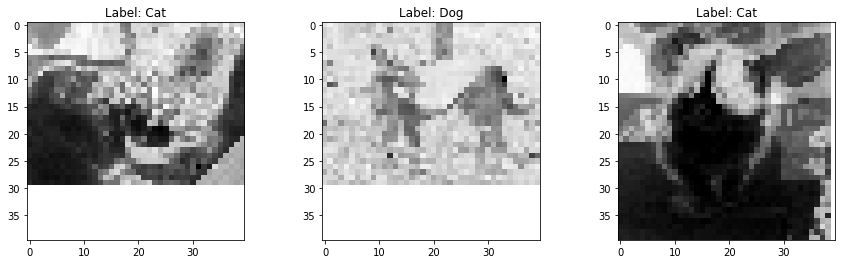

In [97]:
num_imgs = 3
x_batch_imgs, label_batch_imgs = fetch_batch(num_imgs, train_dataset, train_labels)
x_batch = prep_images(x_batch_imgs)
label_batch = np.array([1 if 'dog' in i else 0 for i in label_batch_imgs])

f, axes = plt.subplots(1, num_imgs, figsize=(15,4))
for (i, ax) in enumerate(axes):
    ax.imshow(x_batch[i], cmap='binary')
    label = 'Cat'
    if label_batch[i] == 1:
        label = 'Dog'
    ax.set_title('Label: ' + label)

In [98]:
tf.reset_default_graph()

INPUT_DIM = (IMAGE_SIZE, IMAGE_SIZE, 1)
CLASSES = 2
LEARNING_RATE = 0.001

caps_net = CapsNet(INPUT_DIM, CLASSES,
                   decoder_layers=(512, 1024))

optimizer = tf.train.AdamOptimizer(LEARNING_RATE)
training_op = optimizer.minimize(caps_net.loss)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [102]:
EPOCHES = 5
BATCH_SIZE = 30
TEST_SIZE = 50

train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []
imgs_data = []

# mnist_num_batches = int(len(mnist_x_train)/BATCH_SIZE)
n_batches = int(np.ceil(train_dataset.shape[0] / BATCH_SIZE))
for i in range(EPOCHES):
    x_batch_imgs, label_batch_imgs = fetch_batch(TEST_SIZE, valid_dataset, valid_labels)
    x_batch = prep_images(x_batch_imgs)
    label_batch = np.array([1 if 'dog' in i else 0 for i in label_batch_imgs])
    x_batch = np.reshape(x_batch, (TEST_SIZE, IMAGE_SIZE, IMAGE_SIZE, 1))
#     mnist_x_batch_test, mnist_y_batch_test = next_batch(TEST_SIZE, mnist_x_test, mnist_y_test)
#     mnist_x_batch_test = np.reshape(mnist_x_batch_test, (TEST_SIZE, 28, 28, 1))
    feed_dict_test = {
        caps_net.X: x_batch,
        caps_net.Y: label_batch
    }
    margin_loss = sess.run(caps_net.margin_loss, feed_dict=feed_dict_test)
    decoder_loss = sess.run(caps_net.decoder_loss, feed_dict=feed_dict_test)
    loss = sess.run(caps_net.loss, feed_dict=feed_dict_test)
    accuracy = sess.run(caps_net.accuracy, feed_dict=feed_dict_test)
    print('Epoch %d, test margin loss %f' %(i, margin_loss))
    print('Epoch %d, test decoder loss %f' %(i, decoder_loss))
    print('Epoch %d, test total loss %f' %(i, loss))
    print('Epoch %d, test accuracy %f' %(i, accuracy))
    test_accuracy.append(accuracy)
    test_losses.append([i, margin_loss, decoder_loss, loss])
#     imgs_data.append(get_decoded_data(IMAGES_TO_SHOW))
    for j in range(n_batches):
        x_batch_imgs, label_batch_imgs = next_batch(train_dataset, train_labels, j, BATCH_SIZE)
        x_batch = prep_images(x_batch_imgs)
        label_batch = np.array([1 if 'dog' in i else 0 for i in label_batch_imgs])
        x_batch = np.reshape(x_batch, (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 1))
#         mnist_x_batch, mnist_y_batch = next_batch(BATCH_SIZE, mnist_x_train, mnist_y_train)
#         mnist_x_batch = np.reshape(mnist_x_batch, (BATCH_SIZE, 28, 28, 1))
        feed_dict_train = {
            caps_net.X: x_batch,
            caps_net.Y: label_batch
        }
        sess.run(training_op, feed_dict=feed_dict_train)
        if j % 1 == 0 or j == n_batches-1:
            margin_loss = sess.run(caps_net.margin_loss, feed_dict=feed_dict_train)
            decoder_loss = sess.run(caps_net.decoder_loss, feed_dict=feed_dict_train)
            loss = sess.run(caps_net.loss, feed_dict=feed_dict_train)
            accuracy = sess.run(caps_net.accuracy, feed_dict=feed_dict_train)
            train_accuracy.append(accuracy)
            train_losses.append([i, margin_loss, decoder_loss, loss])
            print('\rEpoch: {}, Iter: {}/{} ({:.1f}%),  Loss: {:.5f}, Accuracy: {:.5f}'.format(
                i, j, n_batches, j * 100 / n_batches, loss, accuracy), end='')
    print('')

Epoch 0, test margin loss 0.404200
Epoch 0, test decoder loss 0.102586
Epoch 0, test total loss 0.404251
Epoch 0, test accuracy 0.460000
Epoch: 0, Iter: 14/832 (1.7%),  Loss: 0.40345, Accuracy: 0.60000

KeyboardInterrupt: 

In [6]:
TRAIN_DIR = './data/train/'
TEST_DIR = './data/test1/'

IMAGE_SIZE = 50;
CHANNELS = 3

valid_size = 50
pixel_depth = 255.0

train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]

def read_image(file_path):
  img = cv2.imread(file_path, cv2.IMREAD_COLOR)
  if (img.shape[0] >= img.shape[1]):
    resizeto = (IMAGE_SIZE, int(round(IMAGE_SIZE * (float(img.shape[1]) / img.shape[0]))))
  else:
    resizeto = (int(round(IMAGE_SIZE * (float(img.shape[0])  / img.shape[1]))), IMAGE_SIZE)
  img = cv2.resize(img, (resizeto[1], resizeto[0]), interpolation=cv2.INTER_CUBIC)
#   img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_CUBIC)
  img = cv2.copyMakeBorder(img, 0, IMAGE_SIZE - img.shape[0], 0,
    IMAGE_SIZE - img.shape[1], cv2.BORDER_CONSTANT, 0)
  return img[:,:,::-1]

def prep_images(images, normalize=True):
  count = len(images)
  data = np.ndarray((count, IMAGE_SIZE, IMAGE_SIZE, CHANNELS), dtype=np.float32)
#   for i in tqdm(range(count)):
  for i in range(count):
    image = read_image(images[i])
    image_data = np.array(image, dtype=np.float32)
    if normalize:
      image_data[:,:,0] = image_data[:,:,0].astype(float) / pixel_depth
      image_data[:,:,1] = image_data[:,:,1].astype(float) / pixel_depth
      image_data[:,:,2] = image_data[:,:,2].astype(float) / pixel_depth
    data[i] = image_data
  return data

def randomize_data(data):
  data = np.array(data)
  permutation = np.random.permutation(data.shape[0])
  shuffled_data = data[permutation]
  return shuffled_data

train_images = randomize_data(train_images)

# train_labels = np.array([1 if 'dog' in i else 0 for i in train_images[:3000]])
# train_normalized = prep_images(train_images[:3000])

print("Train dataset shape: {}".format(train_images.shape))

# plt.imshow(train_normalized[0,:,:,:])
# plt.show()

# train_dataset, train_labels = train_normalized, train_labels

def create_val_set(data, labels, valid_size):
  data_size = data.shape[0]
  all_indices = np.array((range(data_size)))
  val_indices = np.random.choice(range(data_size), valid_size, replace=False)
  train_indices = np.delete(all_indices, val_indices)
  data_train = np.delete(data, val_indices, axis=0)
  label_train = np.delete(labels, val_indices, axis=0)
  data_val = np.delete(data, train_indices, axis=0)
  label_val = np.delete(labels, train_indices, axis=0)
  return data_train, label_train, data_val, label_val

train_dataset, train_labels,\
valid_dataset, valid_labels = create_val_set(train_images, train_images, valid_size)

print('Train dataset shape: {}'.format(train_dataset.shape))
print('Train labels shape: {}'.format(train_labels.shape))
print('Validation dataset shape: {}'.format(valid_dataset.shape))
print('Validation labels shape: {}'.format(valid_labels.shape))

Train dataset shape: (25000,)
Train dataset shape: (24950,)
Train labels shape: (24950,)
Validation dataset shape: (50,)
Validation labels shape: (50,)


In [4]:
# TRAIN_DIR = './data/train/'
# TEST_DIR = './data/test1/'
# ordered_files = sorted(os.listdir(TEST_DIR), key=lambda x: (int(re.sub('\D','',x)),x))
# test_images =  [TEST_DIR+i for i in ordered_files]
# print(len(test_images))

12500


In [10]:
def fetch_batch(x, y, batch_index, batch_size):
  start = batch_index*batch_size
  end = batch_index*batch_size+batch_size
  x_batch = x[start:end]
  if y is not None:
    y_batch = y[start:end]
    return x_batch, y_batch
  else:
    return x_batch

In [13]:
tf.reset_default_graph()

INPUT_DIM = (50, 50, 3)
CLASSES = 10
LEARNING_RATE = 0.001

caps_net = CapsNet(INPUT_DIM, CLASSES,
                   decoder_layers=(512, 1024))

optimizer = tf.train.AdamOptimizer(LEARNING_RATE)
training_op = optimizer.minimize(caps_net.loss)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)